In [1]:
import numpy as np 
import os 
import sys
sys.path.insert(1, '/its/home/drs25/Documents/GitHub/Quadruped/Code')
sys.path.insert(1, '/its/home/drs25/Quadruped/Code')
sys.path.insert(1, 'C:/Users/dexte/Documents/GitHub/Quadruped/Code')
import matplotlib.pyplot as plt
import pickle 
from environment import *
from CPG import *
directory="/its/home/drs25/Quadruped/models/noclipsin/"
from IPython.display import clear_output

pybullet build time: Jan 29 2025 23:16:28
2026-01-16 11:02:41.230528: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load in the data from one folder and sort characteristics

In [2]:
#go into folder
files = [f for f in os.listdir(directory)
         if os.path.isfile(os.path.join(directory, f))]

dictionary={}
#list file types
for file in files:
    unique=file.replace("genotypes","").replace("history","").replace("fitnesses","").replace(".npy","").replace(".pkl","")
    details=file.split("_")
    if dictionary.get(unique,False)==False:
        dictionary[unique]={}
    dictionary[unique]["dt"]=float(details[1].replace("dt",""))
    dictionary[unique]["trial"]=int(details[3])
    dictionary[unique]["friction"]=float(details[4].replace("friction","").replace(".npy","").replace(".pkl",""))
    if len(details)>5:
        dictionary[unique]["Fitness"]=details[5].replace(".npy","").replace(".pkl","")
#gather information
def gather_by_friction(data,friction):
    fitnesses=[]
    genotypes=[]
    history=[]
    for key in data:
        details=data[key]
        if details['friction']==friction:
            fitnesses.append(np.load(directory+"fitnesses"+key+".npy"))
            history.append(np.load(directory+"history"+key+".npy"))
            genotypes.append(directory+"genotypes"+key+".pkl")
    return fitnesses,history,genotypes
def gather_by_trial(data,trial):
    fitnesses=[]
    genotypes=[]
    history=[]
    for key in data:
        details=data[key]
        if details['trial']==trial:
            fitnesses.append(np.load(directory+"fitnesses"+key+".npy"))
            history.append(np.load(directory+"history"+key+".npy"))
            genotypes.append(directory+"genotypes"+key+".pkl")
    return fitnesses,history,genotypes 
def gather_all(data):
    fitnesses=[]
    genotypes=[]
    history=[]
    for key in data:
        details=data[key]
        fitnesses.append(np.load(directory+"fitnesses"+key+".npy"))
        history.append(np.load(directory+"history"+key+".npy"))
        genotypes.append(directory+"genotypes"+key+".pkl")
    return fitnesses,history,genotypes


def gather_histories(genotypes,fitnesses):
    histories=[]
    for i in range(len(genotypes)):
        try:
            best_geno=np.argmax(fitnesses[i])
            with open(genotypes[i], 'rb') as f:
                population = pickle.load(f)
            histories.append(population[best_geno])
        except EOFError:
            print("error loading... corruption")
            histories.append(None)
    return histories
def gather_trajectories(cpgs):
    traj=[]
    for i in range(len(cpgs)):
        clear_output(wait=True)
        print(i,"/",len(cpgs))
        env=environment(0)
        fit,hist,photos=env.runTrial(cpgs[i],100,delay=0) #uses a default fitness
        traj.append(hist['positions'])
    return traj
def gather_o_w(cpgs):
    outputs=[]
    omega=[]
    motors=[]
    for i in range(len(cpgs)):
        o=[]
        w=[]
        clear_output(wait=True)
        print(i,"/",len(cpgs))
        for step in range(1000):
            motor=cpgs[i].get_positions(np.array([0,0,0]))#env.runTrial(cpgs[i],100,delay=0) #uses a default fitness
            o.append(cpgs[i].outputs[0:3])
            w.append(cpgs[i].omega)
            motors.append(motor)
        outputs.append(o)
        omega.append(w)
    return np.array(outputs),np.array(omega),np.array(motors)
f,h,g=gather_by_friction(dictionary,0.5)
cpgs=gather_histories(g,f)
o,w,m=gather_o_w(cpgs)
#trajs=gather_trajectories(cpgs)]


## plot history information

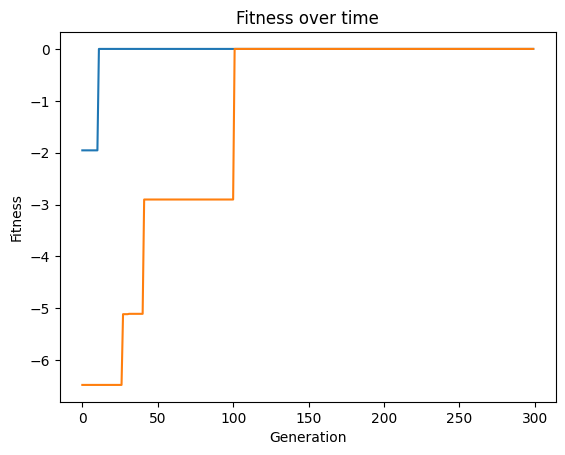

In [3]:
# look at average fitness
f,h,g=gather_all(dictionary)
for i in range(len(h)):
    plt.plot(h[i])
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness over time")
plt.show()

In [4]:
# look at top trajectories
f,h,g=gather_all(dictionary)
cpgs=gather_histories(g,f)
trajs=gather_trajectories(cpgs)
for i in range(len(trajs)):
    traj=np.array(trajs[i])
    plt.plot(traj[:,0],traj[:,1])
plt.ylabel("Y position (meters)")
plt.xlabel("X position (meters)")
plt.title("Trajectories of best CPGs")
plt.show()

0 / 2


AttributeError: 'CTRNNQuadruped' object has no attribute 't'

In [ ]:
# Look at omega and outputs
f,h,g=gather_all(dictionary)
cpgs=gather_histories(g,f)
o,w,m=gather_o_w(cpgs)

n_plots = 6
time = o.shape[1]
try:
    trial_idxs = np.random.choice(o.shape[0], n_plots, replace=False)
except:
    trial_idxs = [0,0,0,0,0,0]

fig, axes = plt.subplots(3, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, idx in zip(axes, trial_idxs):
    ax.plot(o[idx, :, 0], label="hip")
    ax.plot(o[idx, :, 1], label="knee/ankle")
    ax.set_title(f"Trial {idx}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.legend()

plt.tight_layout()
plt.show()

0 / 2


AttributeError: 'CTRNNQuadruped' object has no attribute 't'

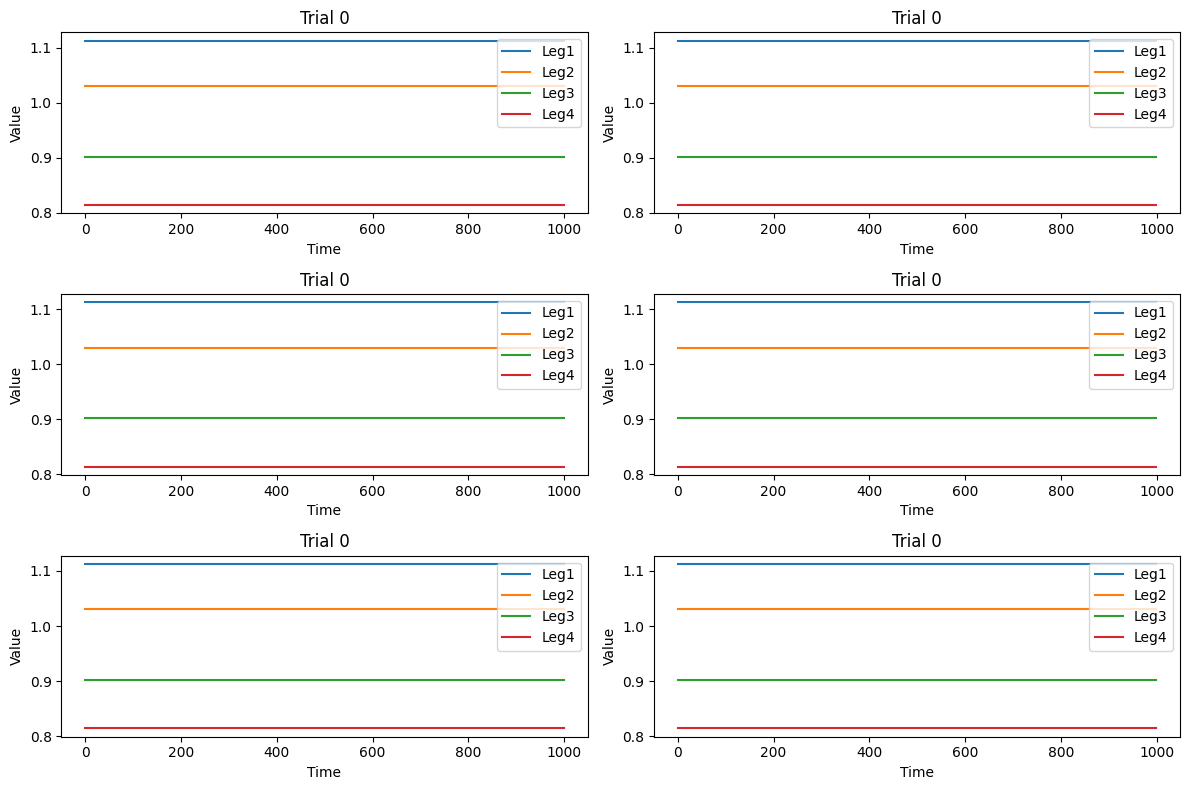

In [ ]:

n_plots = 6
time = w.shape[1]

fig, axes = plt.subplots(3, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, idx in zip(axes, trial_idxs):
    ax.plot(w[idx, :, 0], label="Leg1")
    ax.plot(w[idx, :, 1], label="Leg2")
    ax.plot(w[idx, :, 2], label="Leg3")
    ax.plot(w[idx, :, 3], label="Leg4")
    ax.set_title(f"Trial {idx}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.legend()

plt.tight_layout()
plt.show()

## Retrial and gather from step function the values